### Dependencies

In [1]:
# dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

### Import wine quality dataset

We use the open source wine quality dataset containing various chemical properties, wine color, and quality. We will be predicting the quality.

In [2]:
# load the datasets
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

# add a column to indicate whether the wine is red (using int instead of boolean for .describe)
red_wine['is red'] = 1
white_wine['is red'] = 0

# combine the datasets into a single DataFrame
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

# let's see it
print('rows, cols:', wine_data.shape)
wine_data.head()

rows, cols: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


### Descriptive Statistics

The first we do is a simple inspection of the distribution of the data. Pandas has a great built-in method for summarizing key tendencies.

In [3]:
# let's see some stats
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is red
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


Observations

1. There are no missing values!
2. It looks like ~25% of the wines are red (see rightmost column).
3. The mean (~5.82) and median (6) of the quality are close, indicating only a small skew.
4. The features density and pH have small variance (see std row), but that is not necessarily equal to less prediction power.
5. ...

### Relationship Between Variables using a Correlation Heatmap

The next do is look at the relationships between the variables (features and target) to see which ones has predictive power, and which ones offer redundant information. For this purpose, a correlation heatmap can be useful.

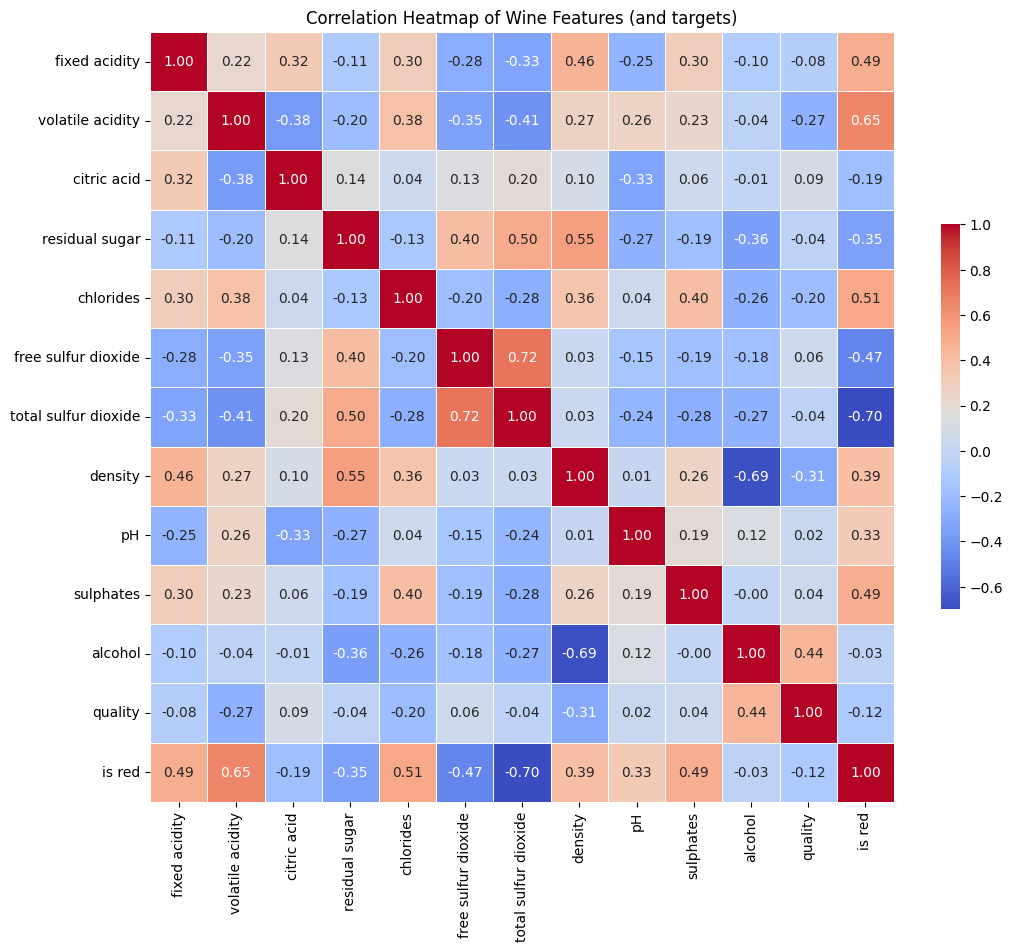

In [36]:
# pandas has a built-in correlation method
corr = wine_data.corr()

# init a matplotlib figure for displaying
plt.figure(figsize=(12, 10))

# use seaborn for a neat heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={'shrink': .5})

# we can also add a title
plt.title('Correlation Heatmap of Wine Features (and targets)')

plt.show()

It looks like a high alcohol percentage has a reasonable positive correlation with quality, while volatile acidity and density has a slightly smaller negative correlation. However, it also looks like alcohol correlates with density, so let's try to stick with alcohol and volatile acidity as features.

In [4]:
# first split the data into features and target variable
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

# subselect only the chosen features for OLS
X_OLS = X[['alcohol', 'volatile acidity']]

# split the data into training and testing sets (we use the same random state to keep the same X->y relation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_OLS_train, X_OLS_test = train_test_split(X_OLS, test_size=0.2, random_state=7)

# fit the OLS model
ols_model = LinearRegression()
ols_model.fit(X_OLS_train, y_train)

# fit the ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# fit the lasso regression model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# predict
ols_pred = ols_model.predict(X_OLS_test)
ridge_pred = ridge_model.predict(X_test)
lasso_pred = lasso_model.predict(X_test)

# evaluate using MSE
ols_mse = mean_squared_error(y_test, ols_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)
lasso_mse = mean_squared_error(y_test, lasso_pred)

print("OLS Mean Squared Error:", ols_mse)
print("Ridge Mean Squared Error:", ridge_mse)
print("Lasso Mean Squared Error:", lasso_mse)

OLS Mean Squared Error: 0.5467507185219003
Ridge Mean Squared Error: 0.5259876303504061
Lasso Mean Squared Error: 0.576548821940421


### What does this mean?

- Which model performed the best?
- What could be done to improve performance in general and for specific models?